# Mask R-CNN - Train on Shapes Dataset

### Notes from implementation

This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 


In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import math
import re
import  gc
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pprint
import keras.backend as KB
sys.path.append('../')

import mrcnn.model     as modellib
import mrcnn.visualize as visualize
import mrcnn.shapes    as shapes
from mrcnn.config      import Config
from mrcnn.model       import log
from mrcnn.dataset     import Dataset 
# from mrcnn.pc_layer    import PCTensor
# from mrcnn.pc_layer   import PCNLayer

# Root directory of the project
ROOT_DIR = os.getcwd()
MODEL_PATH = 'E:\Models'
# Directory to save logs and trained model
MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")
# Path to COCO trained weights
COCO_MODEL_PATH   = os.path.join(MODEL_PATH, "mask_rcnn_coco.h5")
RESNET_MODEL_PATH = os.path.join(MODEL_PATH, "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

print("Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100)

# Build configuration object -----------------------------------------------
config = shapes.ShapesConfig()
config.BATCH_SIZE      = 4                   #Batch size is 2 (# GPUs * images/GPU).
config.IMAGES_PER_GPU  = 4
config.STEPS_PER_EPOCH = 2
# config.IMAGES_PER_GPU  = 1
config.FCN_INPUT_SHAPE = config.IMAGE_SHAPE[0:2]
config.display() 

# Build shape dataset        -----------------------------------------------

from mrcnn.datagen import data_generator, load_image_gt

# Training dataset
# generate 500 shapes 
dataset_train = shapes.ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = shapes.ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

# Load and display random samples
# image_ids = np.random.choice(dataset_train.image_ids, 3)
# for image_id in [3]:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
print(' COCO Model Path       : ', COCO_MODEL_PATH)
print(' Checkpoint folder Path: ', MODEL_DIR)

In [6]:
# del dataset_train,dataset_val
# del model
# gc.collect()
# sess = KB.get_session()
# sess.close()
# import tensorflow as tf
# # print("Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__))
# dir(tf)

## Process outside of training 

### Create Model

In [8]:
try :
    del model, train_generator, val_generator, mm
    gc.collect()
except: 
    pass

model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
#model.keras_model.summary(line_length = 120) 

# Which weights to start with?
init_with = "last"  # imagenet, coco, or last
if init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that are different due to the different number of classes
    # See README for instructions to download the COCO weights
    loc=model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    loc= model.load_weights(model.find_last()[1], by_name=True)

model.compile_only(learning_rate=config.LEARNING_RATE, layers='heads')
KB.set_learning_phase(1)

>>> Set_log_dir() -- model dir is  E:\Models\mrcnn_logs
    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180415T2026\mask_rcnn_shapes_{epoch:04d}.h5
>>> Generate pyramid anchors 
    Size of anchor array is : (4092, 4)
>>> RPN Outputs  <class 'list'>
      rpn_class_logits_1/concat:0
      rpn_class_1/concat:0
      rpn_bbox_1/concat:0
>>> Proposal Layer init complete. Size of anchors:  (4092, 4)
     Scores :  (4, 4092)
     Deltas :  (4, 4092, 4)
     Anchors:  (4, 4092, 4)
     Boxes shape / type after processing:  (4, 4092, 4) <class 'tensorflow.python.framework.ops.Tensor'>
>>> Detection Target Layer : initialization
>>> Detection Target Layer : call  <class 'list'> 4
     proposals.shape    : (4, ?, ?) <class 'tensorflow.python.framework.ops.Tensor'>
     gt_class_ids.shape : (?, ?) <class 'tensorflow.python.framework.ops.Tensor'>
     gt_bboxes.shape    : (?, ?, 4) <class 'tensorflow.python.framework.ops.Tensor'>
     gt_masks.shape     : (?, 56, 56, ?) <cl

>>> mrcnn_mask_loss_graph 
    target_class_ids size : (?, 1)
    target_masks     size : (?, 32, 28, 28)
    pred_masks       size : (?, 32, 28, 28, 4)
>>> MaskRCNN build complete
>>> MaskRCNN initialization complete
>>> find_last checkpoint file() 
    find_last info:   dir_name: E:\Models\mrcnn_logs\shapes20180313T1856
    find_last info: checkpoint: E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_0242.h5
>>> load_weights()
    load_weights: Loading weights from: E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_0242.h5
    load_weights: Log directory set to : E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_0242.h5
>>> Set_log_dir() -- model dir is  E:\Models\mrcnn_logs
    set_log_dir: model_path (input) is : E:/Models/mrcnn_logs/shapes20180313T1856/mask_rcnn_shapes_0242.h5  
    set_log_dir: self.epoch set to 243  (Next epoch to run)
    set_log_dir: tensorboard path: E:\Models\mrcnn_logs\tensorboard
    set_log_dir: Checkpoint path set to : E:\Models\m

###  Print some model information 

In [ ]:

# mm = model.keras_model
# print('\n Learning phase values is L ' ,KB.learning_phase())
# print('\n Metrics (_get_deduped_metrics_names():) ') 
# pp.pprint(mm._get_deduped_metrics_names())
# print('\n Outputs: ') 
# pp.pprint(mm.outputs)
# print('\n Losses (model.metrics_names): ') 
# pp.pprint(mm.metrics_names)

# model.keras_model.summary(line_length = 120) 

### Define Data Generator

In [9]:
train_generator = data_generator(dataset_train, model.config, shuffle=True,
                                 batch_size=model.config.BATCH_SIZE,
                                 augment = False)
val_generator = data_generator(dataset_val, model.config, shuffle=True, 
                                batch_size=model.config.BATCH_SIZE,
                                augment=False)

### Get next shapes from generator and display loaded shapes

In [10]:
train_batch_x, train_batch_y = next(train_generator)

>>> Generate pyramid anchors 
    Size of anchor array is : (4092, 4)


### Display loaded shapes

Image id:  371
Image meta [371 128 128   3   0   0 128 128   1   1   1   1]
[1 2]


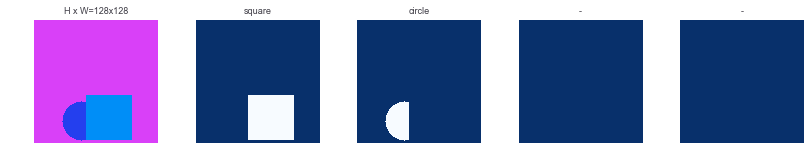

Image id:  222
Image meta [222 128 128   3   0   0 128 128   1   1   1   1]
[2 3 1 2]


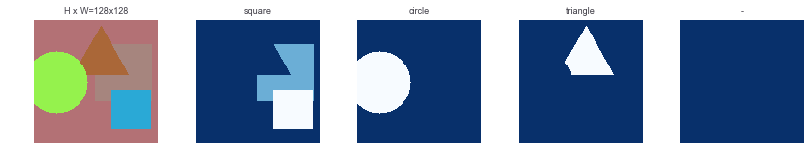

Image id:  259
Image meta [259 128 128   3   0   0 128 128   1   1   1   1]
[1 3 1]


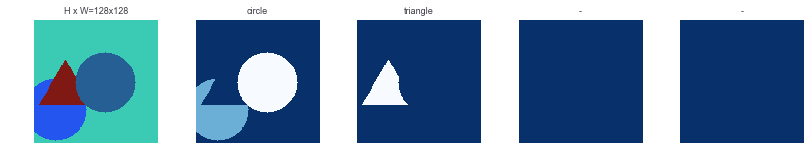

Image id:  1
Image meta [  1 128 128   3   0   0 128 128   1   1   1   1]
[2 2 3]


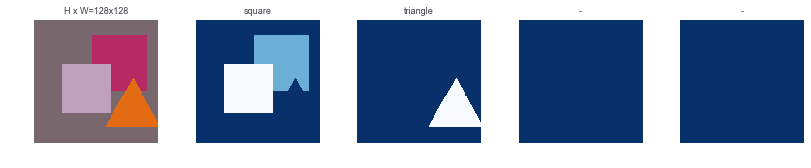

In [11]:
# train_batch_x, train_batch_y = next(train_generator)
imgmeta_idx = model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)



In [ ]:
# from   mrcnn.utils            import parse_image_meta_graph
# a,b,c,d = parse_image_meta_graph(img_meta)

### Push Data thru model using get_layer_output()

In [12]:
from mrcnn.callbacks import get_layer_output_1,get_layer_output_2
np.set_printoptions(linewidth=100,precision=4)
pp = pprint.PrettyPrinter(indent=4)

In [13]:
layers_out = get_layer_output_2(model.keras_model, train_batch_x, 1)


/* Inputs */
Input 0:  (input_image             ) 	  Input shape: (4, 128, 128, 3)
Input 1:  (input_image_meta        ) 	  Input shape: (4, 12)
Input 2:  (input_rpn_match         ) 	  Input shape: (4, 4092, 1)
Input 3:  (input_rpn_bbox          ) 	  Input shape: (4, 256, 4)
Input 4:  (input_gt_class_ids      ) 	  Input shape: (4, 100)
Input 5:  (input_gt_boxes          ) 	  Input shape: (4, 100, 4)
Input 6:  (input_gt_masks          ) 	  Input shape: (4, 56, 56, 100)
num rois : 32
===  Build Gaussian np for detected rois =========================
   input_tensor shape is  (4, 4, 32, 8)
   num of bboxes per class is :  32
 COVARIANCE SHAPE: (32, 2)
====> Img:  0
 ===> mns shape  (32, 2) coar.shape  (32, 2)
  pdf_arr.shape :  (128, 128, 30)
   *** img:  0  cls: 0   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
   *** img:  0  cls: 1   [21 22 23 24 25 26 27]
   *** img:  0  cls: 2   [28 29]
   *** img:  0  cls: 3   []
====> Img:  1
 ===> mns shape  (32, 2) coar.shape  (

### Control pred_tensor / pred_tensor2

In [ ]:
for i in range(100):
    train_batch_x, train_batch_y = next(train_generator)

    layers_out = get_layer_output_2(model.keras_model, train_batch_x, 1, verbose = False)

    pt   = layers_out[8]   # pred_tensor
    pcc  = layers_out[9]   # pred_cls_cnt

    pt2  = layers_out[12]  # pred_TNESOR_2
    pcc2 = layers_out[13]  # pred_cls_cnt_2

    # print( pt2.shape, pcc2.shape)
    # print( pt.shape, pcc.shape)
    # print(pc2)

    for img in range(config.BATCH_SIZE):
        for cls in range(4):
        #     print(pt2[img][cls])
        #     print(pt[img][cls])
            equal = np.all(pt2[img][cls]== pt[img][cls,:,:7], axis = -1)

            if (~equal.all()):
                print(' Iteration', i , 'Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
                print(equal)
                print('\n -- using numpy \n',pt[img][cls,~equal,:-1])
                print('\n -- using tensorflow \n',pt2[img][cls,~equal])
                print()
    #             print('\n -- using numpy \n',pt[img][cls])            
    #             print('\n -- using tensorflow \n',pt2[img][cls])
    

### Control means, covar / means2, covar2

In [ ]:
mns  = layers_out[5]   # pred_tensor
cov  = layers_out[6]   # pred_cls_cnt

mns2 = layers_out[15]  # pred_TNESOR_2
cov2 = layers_out[16]  # pred_cls_cnt_2


print( mns.shape, mns2.shape)
# print( pt.shape, pcc.shape)
# print(pc2)

for img in range(config.BATCH_SIZE):
    for cls in range(4):
        equal = np.all(mns[img][cls]== mns2[img][cls], axis = -1)
        print('Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
#         print('mns  :')
#         print(mns[img])
#         print('mns2 :')
#         print(mns2[img])

        if (~equal.all()):
            print('Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
            print(equal)
            print('\n -- numpy      \n', mns[img][cls,~equal,:-1])
            print('\n -- tensorflow \n', mns2[img][cls,~equal])
            print()
#             print('\n -- using numpy \n',pt[img][cls])            
#             print('\n -- using tensorflow \n',pt2[img][cls])
    

### Control pred_tesnor / pred_tensor2

In [ ]:
pt   = layers_out[10]   # pred_tensor
pt2  = layers_out[17]   # pred_cls_cnt
 
# print( pt2.shape, pcc2.shape)
print( pt.shape, pt2.shape)
# print(pc2)

for img in range(config.BATCH_SIZE):
    for cls in range(4):
        equal = np.all(pt[img][cls,:,1:7] == pt2[img][cls,:,1:7], axis = -1)
        print('Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
#         print( pt[img,cls])
#         print()
#         print(pt2[img,cls])



        if (~equal.all()):
#             print('Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
            print(equal)
            print('\n -- using numpy (pt) \n',pt[img][cls,~equal,:-1])
            print('\n -- using tensorflow (pt2) \n',pt2[img][cls,~equal])
            print()
#             print('\n -- using numpy \n',pt[img][cls])            
#             print('\n -- using tensorflow \n',pt2[img][cls])
    

### Control pred_cls_cnt / pred_cls_cnt2

In [ ]:
 

pt  = layers_out[11]   # pred_cls_cnt
pt2 = layers_out[18]  # pred_cls_cnt_2


# print( pt2.shape, pcc2.shape)
# print( pt.shape, pcc.shape)
# print(pc2)

for img in range(config.BATCH_SIZE):
    print('  pt2  ', pt2[img])
    print('  pt   ', pt[img])
    equal = np.all(pt2[img]== pt[img], axis = -1)

    if (~equal.all()):
        print('Image ',img, ' ALL EQUAL: ',equal.all())
        print(equal)
        print('\n -- using numpy \n',pt[img][~equal])
        print('\n -- using tensorflow \n',pt2[img][~equal])
        print()
#             print('\n -- using numpy \n',pt[img][cls])            
#             print('\n -- using tensorflow \n',pt2[img][cls])
    

###  pred_gaussian / pred_gaussian2

In [ ]:
pt   = layers_out[4]   # pred_gaussian 
pt2  = layers_out[14]  # pred_gaussian_2

print( ' pt shape ', pt.shape, ' pt2.shape ', pt2.shape)

for img in range(config.BATCH_SIZE):
    print(' from np ')
    print(pt[img])
    print(' from tensorflow')
    print(pt2[img])

    for cls in range(4):

        equal = np.all(pt2[img, cls]== pt[img, cls], axis = -1)
        
# #         print('\n -- using numpy \n',pt[img][cls])            
# #         print('\n -- using tensorflow \n',pt2[img][cls])
        print( 'Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
        
        
#         if (~equal.all()):
#             print( 'Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
#             print(equal)
#             print('\n -- using numpy \n',pt[img][cls,~equal,:-1])
#             print('\n -- using tensorflow \n',pt2[img][cls,~equal])
#             print()
# #             print('\n -- using numpy \n',pt[img][cls])            
# #             print('\n -- using tensorflow \n',pt2[img][cls])
    

In [ ]:
out_rois = layers_out[0]
out_rois[0] * np.array([128,128,128,128])  

In [ ]:
imgmeta_idx = model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

image_id = img_meta[0,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

image_id = img_meta[1,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

#### Plot mask in string format

In [ ]:
# np.set_printoptions(threshold=99999, linewidth=2000)
# print(np.array2string(mask[...,0],max_line_width=2000,separator=''))
 

In [ ]:
outmask0 = layers_out[14][0,:,:,:,1] ##  mrcnn_mask
np.max(outmask0)

### Plot Predicition Probability Tensors

In [ ]:
%matplotlib notebook
from mrcnn.visualize import plot_gaussian
Zout = layers_out[4]
Zout2 = layers_out[14]
num_images = config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES
for img in range(num_images):
    for cls in range(num_classes):
        ttl = 'image :  {} class: {} '.format(img,cls)
        plot_gaussian(Zout[img,cls], title = ttl)
        plot_gaussian(Zout2[img,cls], title = ttl)        

### Plot Ground Truth Probability tensors

In [ ]:
# i = 1
# print(layers_out[i].shape)      #[0,0,0:20, 0:20]
Zout = layers_out[14]
num_images = config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES
for img in range(num_images):
    for cls in range(num_classes):
        ttl = 'image :  {} class: {} '.format(img,cls)
        plot_gaussian(Zout[img,cls], title = ttl)

### Display predicted bounding boxes - calculate center and width/height of bboxes displayed 

In [ ]:
from mrcnn.utils import trim_zeros
np.set_printoptions( edgeitems=32, suppress=True)
pred_bb = layers_out[3]
print(pred_bb.shape)
x0 = [ trim_zeros((pred_bb[0,i,:,:])) for i in range(4)]
ps0 = np.concatenate( x0, axis=0 )

x1 = [ trim_zeros((pred_bb[1,i,:,:])) for i in range(4)]
ps1 = np.concatenate( x1, axis=0 )
# print(np.concatenate( x1, axis=0 ))
print(ps0)
print(ps0.shape)
width  = ps0[:,5] - ps0[:,3]
height = ps0[:,4] - ps0[:,2]
cx     = ps0[:,3] + ( width  / 2.0)
cy     = ps0[:,2] + ( height / 2.0)
means0  = np.stack((cx,cy,width, height),axis = -1)
print(means0)

#### Output RoIs (Normalized)

In [ ]:
output_rois = layers_out[0]
output_rois[0,:,:]

### Display ground truth bboxes from Shapes database (using load_image_gt)

Here we are displaying the ground truth bounding boxes as provided by the dataset

In [ ]:
image_id = img_meta[0,0]
print('Image id: ',image_id)
p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
print(p_gt_bbox)
visualize.draw_boxes(p_original_image, p_gt_bbox)

image_id = img_meta[1,0]
print('Image id: ',image_id)
p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
print(p_gt_bbox)
visualize.draw_boxes(p_original_image, p_gt_bbox)

### Display bboxes from Ground Truth Info - Input info Passed to Network 

layers_out[5]  gt_tensor is based on input_gt_class_ids and input_normlzd_gt_boxes

Display the Ground Truth bounding boxes from the tensor we've constructed

In [ ]:
np.set_printoptions(linewidth=120, precision=5)
gt_bboxes = layers_out[5]  
print(layers_out[5].shape)
print(' gt_cls_cnt')
print(layers_out[6])
print(layers_out[5][1,3])

In [ ]:
# print(gt_bboxes)
# visualize.display_instances(p_original_image, p_gt_bbox, p_gt_mask, p_gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))
# pp.pprint(gt_bboxes)
img = 0
image_id = img_meta[img,0]
print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
gt_bboxes = layers_out[5]
print(gt_bboxes.shape)
print(gt_bboxes[0,1,0:1,2:6])
print(gt_bboxes[0,2,0:2,2:6])
gt_bb = np.vstack((gt_bboxes[0,1,0:1,2:6],gt_bboxes[0,2,0:2,2:6],gt_bboxes[0,3,0:2,2:6]))
gt_bb.shape
visualize.draw_boxes(p_image, gt_bb)

## Display RoI proposals generated

Display bounding boxes from tensor of proposals produced by the network 
Square: 1 , Circle:2 , Triangle -3

In [ ]:
img = 0
cls = 3  # <==== Class to dispaly
image_id = img_meta[img,0]
print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)

pred_tensor = layers_out[3]
caps = [str(cls)+'-'+str(x) for x in pred_tensor[img,cls,:,0].astype('int16').tolist() ]
print(caps)
# print(pc_tensor.pred_tensor[1,3,:])
# print(pc_tensor.pred_tensor[1,3,:,2:6])
visualize.draw_boxes(p_image, pred_tensor[img,cls,:,2:6], captions = caps)

For each class:
- determine the center of each bounding box.
- center a 2d gaussian distribution with the mean = center of bounding box and sigma = height/width
- place dist on mesh grid
- normalize
- draw heatmap

In [ ]:
np.set_printoptions(precision=5)
from mrcnn.pc_layer import PCTensor
pc_tensor = PCTensor(model)
pc_tensor.build_predictions(sample_x)
print(pc_tensor.pred_stacked)    # list of tensors


### Plot Image 0

In [ ]:
from mrcnn.visualize import plot_gaussian
num_images = config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES
for img in range(num_images):
    for cls in range(num_classes):
        ttl = 'image :  {} class: {} '.format(img,cls)
        plot_gaussian(Zout1[img,cls], title = ttl)

### Plot Image 1

In [ ]:
# img = 0
# cls = 0
# _cnt = pc_tensor.pred_cls_cnt[img,cls]
# print(_cnt)
# for box in range(_cnt):

#     mns = means[img,cls, 0 : _cnt]
#     print('img: ',img, 'class: ', cls, 'class count: ',_cnt, 'shape of mns :',mns.shape)
#     # print('** bbox is : ' ,self.pred_tensor[img,cls,box])
#     # print('    center is ({:4f},{:4f})  width is {:4f} height is {:4f} '\
#         # .format(mns[0],mns[1],width[img,cls,box],height[img,cls,box]))            
#     # fn = lambda x: multivariate_normal(x, [[12,0.0] , [0.0,19]])
#     # rv = tf.map_fn(fn, 
#     rv = np.apply_along_axis(multivariate_normal, 1, mns, [[12,0.0] , [0.0,19]])
#     print('rv :',rv.shape, rv)
#     _zo = rv.pdf(pos[img,cls])
#     print('zo :',_zo.shape)

In [ ]:
tfd = tf.contrib.distributions
k_sess = KB.get_session()

In [ ]:
# pp1 = tf.fill([1,1,32], 12.0)
# pp2 = tf.fill([1,1,32], 19.0)
# pp  = tf.cast(tf.stack((pp1,pp2),axis=-1), dtype=tf.float64)
# tf.cast([12.0, 19.00], dtype=tf.float64)
# pp1.eval(session = k_sess)

# mvn = tfd.MultivariateNormalDiag(means[0,0,0,:],scale_diag=p1)
# mvn = tfd.MultivariateNormalDiag(means[0,0,0,:],scale_diag=p1)

# with k_sess.as_default():
#     print(mvn.mean())
#     print(mvn.batch_shape)
#     print(mvn.event_shape)
#     print(pos[0,0,:,0,0,:].shape)
#     rr = mvn.prob(pos[0,0,:,0,0,:])
#     print(rr)

In [ ]:
# %matplotlib notebook
# from mrcnn.visualize import plot_gaussian
# for i in range(0,config.IMAGES_PER_GPU):
#     for j in range(0,config.NUM_CLASSES):
#         ttl = 'image : {} class: {}'.format(i,j)
#         plot_gaussian(Zout[i,j] , title = ttl )
# # plot_gaussian(Zout[3])


In [ ]:
# Zout = np.zeros((num_classes, 128,128))
for i in range(1,config.NUM_CLASSES):
    print('class: ',i)
    for j in range(gt_cls_cnt[i]):
        Zout[i] = bbox_gaussian(gt_cpb[i,j], Zout[i])
print(Zout.shape)
 
# plot_gaussian(Zout[1])
# plot_gaussian(Zout[3])

## Fine Tuning
Fine tune all layers

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=211,
            layers="all")

## Save 

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

### Create Model

In [ ]:

# del history
try :
    del model
    gc.collect()
except: 
    pass

model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
#model.keras_model.summary(line_length = 120)
# print(model.find_last())

# Which weights to start with?
init_with = "last"  # imagenet, coco, or last
if init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that are different due to the different number of classes
    # See README for instructions to download the COCO weights
    loc=model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    loc= model.load_weights(model.find_last()[1], by_name=True)


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

## Training head using  Keras.model.fit_generator()

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs_to_run =2, 
            layers='heads')

## - Training heads using train_in_batches ()

We need to use this method for the time being as the fit generator does not have provide EASY access to the output in Keras call backs. By training in batches, we pass a batch through the network, pick up the generated RoI detections and bounding boxes and generate our semantic / gaussian tensors ...


In [ ]:
model.train_in_batches(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs_to_run = 2,
            layers='heads')

## Simulate one training iteration - 1

In [ ]:
from mrcnn.datagen import data_generator, load_image_gt
np.set_printoptions(linewidth=100)
learning_rate=model.config.LEARNING_RATE
epochs_to_run = 2
layers='heads'
batch_size = 0
steps_per_epoch = 0
# assert self.mode == "training", "Create model in training mode."
# Pre-defined layer regular expressions
layer_regex = {
    # all layers but the backbone
    "heads": r"(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    # From a specific Resnet stage and up
    "3+": r"(res3.*)|(bn3.*)|(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    "4+": r"(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    "5+": r"(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    # All layers
    "all": ".*",
}

if layers in layer_regex.keys():
    layers = layer_regex[layers]
if batch_size == 0 :
    batch_size = model.config.BATCH_SIZE            
if steps_per_epoch == 0:
    steps_per_epoch = model.config.STEPS_PER_EPOCH

# Data generators
train_generator = data_generator(dataset_train, model.config, shuffle=True,
                                 batch_size=batch_size)
val_generator   = data_generator(dataset_val, model.config, shuffle=True,
                                 batch_size=batch_size,
                                 augment=False)

# Train
log("Last epoch completed : {} ".format(model.epoch))
log("Starting from epoch {} for {} epochs. LR={}".format(model.epoch, epochs_to_run, learning_rate))
log("Steps per epoch:    {} ".format(steps_per_epoch))
log("Batchsize      :    {} ".format(batch_size))
log("Checkpoint Folder:  {} ".format(model.checkpoint_path))
epochs = model.epoch + epochs_to_run

from tensorflow.python.platform import gfile
if not gfile.IsDirectory(model.log_dir):
    log('Creating checkpoint folder')
    gfile.MakeDirs(model.log_dir)
else:
    log('Checkpoint folder already exists')

model.set_trainable(layers)            
model.compile(learning_rate, model.config.LEARNING_MOMENTUM)        

out_labels = model.keras_model._get_deduped_metrics_names()
callback_metrics = out_labels + ['val_' + n for n in out_labels]

progbar = keras.callbacks.ProgbarLogger(count_mode='steps')
progbar.set_model(model.keras_model)
progbar.set_params({
    'epochs': epochs,
    'steps': steps_per_epoch,
    'verbose': 1,
    'do_validation': False,
    'metrics': callback_metrics,
})

progbar.set_model(model.keras_model) 

chkpoint = keras.callbacks.ModelCheckpoint(model.checkpoint_path, 
                                           monitor='loss', verbose=1, save_best_only = True, save_weights_only=True)
chkpoint.set_model(model.keras_model)

progbar.on_train_begin()
epoch_idx = model.epoch

## Simulate one training iteration - 2

In [ ]:
if epoch_idx >= epochs:
    print('Final epoch {} has already completed - Training will not proceed'.format(epochs))

# while epoch_idx < epochs :
progbar.on_epoch_begin(epoch_idx)
steps_index = 0
# for steps_index in range(steps_per_epoch):

batch_logs = {}
print(' self.epoch {}   epochs {}  step {} '.format(model.epoch, epochs, steps_index))
batch_logs['batch'] = steps_index
batch_logs['size']  = batch_size
progbar.on_batch_begin(steps_index, batch_logs)

## Simulate one training iteration - 3

In [ ]:
imgmeta_idx= model.keras_model.input_names.index('input_image_meta')
img_meta  =  train_batch_x[imgmeta_idx]

image_id = img_meta[0,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

image_id = img_meta[1,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

outs = model.keras_model.train_on_batch(train_batch_x, train_batch_y)